The goal of this notebook is the see if the pywake agent and the MPC controlled agent gives the same results. They should!

In [1]:
from mpcrl.mpc import *
import numpy as np
from py_wake.examples.data.hornsrev1 import V80
import matplotlib.pyplot as plt
from windgym.WindGym import PyWakeAgent, WindFarmEnv

/home/marcus/miniconda3/envs/testenv/lib/python3.13/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment WindGym/WindFarmEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
x_pos = np.array([0, 500, 900])
y_pos = np.array([0, 0, 0])
D = 80
APPLY_YAW_PENALTY = False

In [3]:
# We can setup the MPC model like this
mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                          wt=V80(),
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=APPLY_YAW_PENALTY)

[baseline] Total energy: 882137169.84 J  | eval_time: 0.003s

=== Running method: direct ===
[direct] Total energy: 1027254793.68 J  (Δ vs baseline: +16.45%)  | opt_time: 0.178s  eval_time: 0.001s  total: 0.179s

=== Running method: shgo ===
[shgo] Total energy: 1031942952.09 J  (Δ vs baseline: +16.98%)  | opt_time: 0.304s  eval_time: 0.001s  total: 0.305s

=== Running method: sobol_powell ===
[sobol_powell] Total energy: 1032303657.79 J  (Δ vs baseline: +17.02%)  | opt_time: 0.060s  eval_time: 0.001s  total: 0.061s

=== Summary (sorted by energy) ===
                  method          E[J]        Δ%    opt[s]   eval[s]   total[s]
-------------------------------------------------------------------------------
            sobol_powell  1032303657.79     17.02     0.060     0.001      0.061
                    shgo  1031942952.09     16.98     0.304     0.001      0.305
                  direct  1027254793.68     16.45     0.178     0.001      0.179


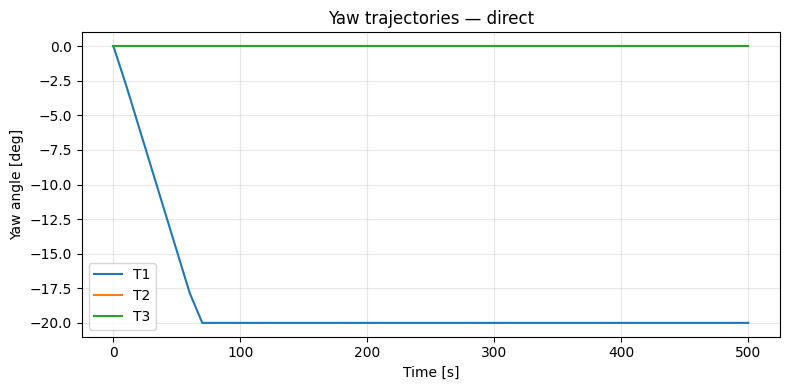

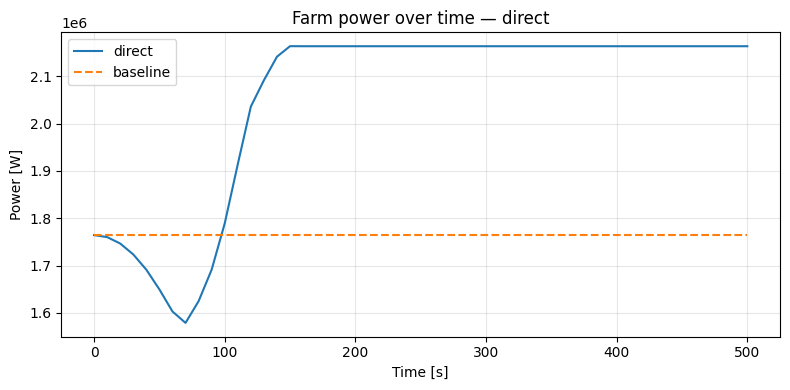

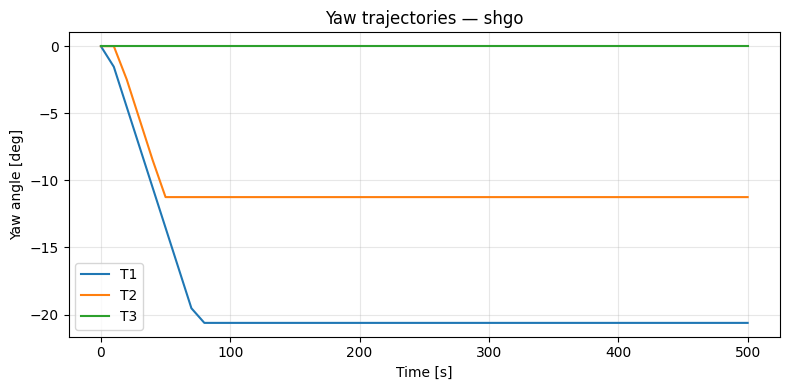

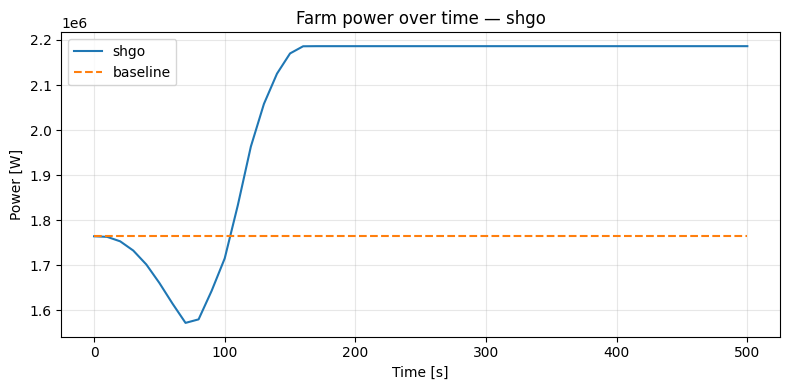

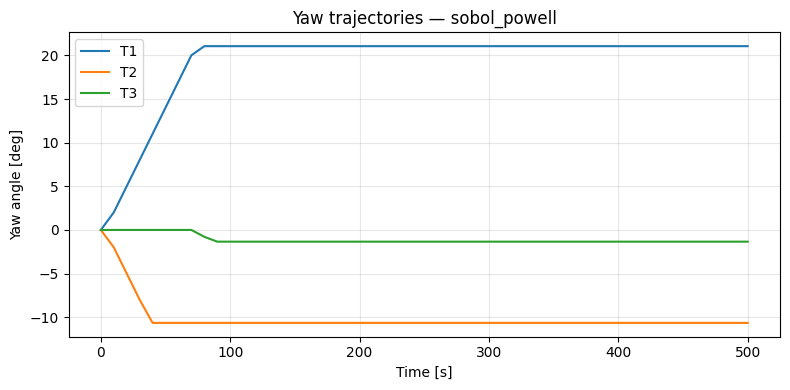

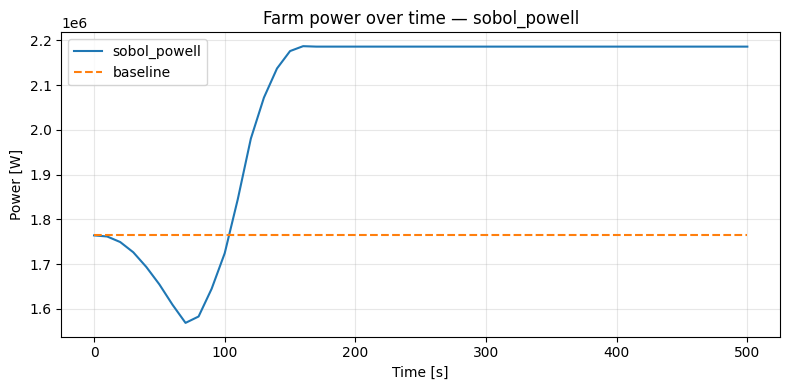

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

# --- CONFIG ---
WS, TI, WD = 10.0, 0.04, 270.0
r_gamma = 0.3
t_AH = 100.0

# Optimization + evaluation budgets
dt_opt = 10.0
T_opt = 600.0
per_turbine_budget = 20        # ~total objective evals per turbine per method

# Final evaluation (can be longer/finer than the optimizer’s)
dt_eval = 10.0
T_eval = 500.0

# Which methods to compare (uncomment as you like)
METHODS = [
    "direct",
    "shgo",
    "sobol_powell",
    # "dual_annealing",
    # "dual_annealing_powell",
    # "gp_bo",
    # "gp_bo_powell",
]

# --- Helpers ---
def zeros_sorted(model):
    return np.zeros(model.n_turbines, dtype=float)

def farm_energy(P_matrix, t):
    # If you already imported this from your module, remove this local def.
    return np.trapezoid(np.sum(P_matrix, axis=0), t)

def evaluate_params(model, params, current_yaw_angles_sorted, r_gamma, t_AH, dt, T):
    """Runs the delay loop + integrates energy and returns timing."""
    t0 = perf_counter()
    t, traj, P = run_farm_delay_loop_optimized(
        model=model,
        yaw_params=params,
        current_yaw_angles_sorted=current_yaw_angles_sorted,
        r_gamma=r_gamma,
        t_AH=t_AH,
        dt=dt,
        T=T,
    )
    E = farm_energy(P, t)
    eval_time = perf_counter() - t0
    return t, traj, P, E, eval_time

# --- PREPARE MODEL ---
mpc_model.update_conditions(U_inf=WS, TI=TI, wd=WD)
current_yaw_angles_sorted = zeros_sorted(mpc_model)

# Baseline (hold yaw: o1=o2=0.5)
hold_params = np.array([[0.5, 0.5]] * mpc_model.n_turbines, dtype=float)
t_base, traj_base, P_base, E_base, t_eval_base = evaluate_params(
    mpc_model, hold_params, current_yaw_angles_sorted, r_gamma, t_AH, dt_eval, T_eval
)
print(f"[baseline] Total energy: {E_base:.2f} J  | eval_time: {t_eval_base:.3f}s")

results = []

for method in METHODS:
    print(f"\n=== Running method: {method} ===")

    # --- OPTIMIZATION TIMING ---
    t0 = perf_counter()
    opt_params = optimize_farm_back2front(
        model=mpc_model,
        current_yaw_angles_sorted=current_yaw_angles_sorted,
        r_gamma=r_gamma,
        t_AH=t_AH,
        dt_opt=dt_opt,
        T_opt=T_opt,
        # maxfun=per_turbine_budget,   # kept for compatibility with dual_annealing etc.
        seed=42,
        use_time_shifted=False,
        method=method,
        per_turbine_budget=per_turbine_budget,
        verbose=False,
    )
    opt_time = perf_counter() - t0
    # print(f"Optimized params:\n{opt_params}")
    # --- EVALUATION TIMING ---
    t, traj, P, E, eval_time = evaluate_params(
        mpc_model, opt_params, current_yaw_angles_sorted, r_gamma, t_AH, dt_eval, T_eval
    )
    gain_pct = (E - E_base) / E_base * 100.0

    print(
        f"[{method}] Total energy: {E:.2f} J  (Δ vs baseline: {gain_pct:+.2f}%)  "
        f"| opt_time: {opt_time:.3f}s  eval_time: {eval_time:.3f}s  total: {opt_time+eval_time:.3f}s"
    )

    results.append({
        "method": method,
        "params": opt_params,
        "t": t,
        "traj": traj,
        "P": P,
        "E": E,
        "gain_pct": gain_pct,
        "opt_time": opt_time,
        "eval_time": eval_time,
        "total_time": opt_time + eval_time,
    })

    # --- PLOTTING ---
    # 1) Yaw trajectories for each turbine
    fig, ax = plt.subplots(figsize=(8, 4))
    for i in range(mpc_model.n_turbines):
        ax.plot(t, traj[i], label=f"T{i+1}")
    ax.set_title(f"Yaw trajectories — {method}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Yaw angle [deg]")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.tight_layout()

    # 2) Farm total power over time
    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(t, P.sum(axis=0), label=f"{method}")
    ax2.plot(t_base, P_base.sum(axis=0), linestyle="--", label="baseline")
    ax2.set_title(f"Farm power over time — {method}")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Power [W]")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="best")
    plt.tight_layout()

# --- SUMMARY TABLE ---
print("\n=== Summary (sorted by energy) ===")
hdr = f"{'method':>24s}  {'E[J]':>12s}  {'Δ%':>8s}  {'opt[s]':>8s}  {'eval[s]':>8s}  {'total[s]':>9s}"
print(hdr)
print("-" * len(hdr))
for r in sorted(results, key=lambda z: z["E"], reverse=True):
    print(
        f"{r['method']:>24s}  {r['E']:12.2f}  {r['gain_pct']:8.2f}  "
        f"{r['opt_time']:8.3f}  {r['eval_time']:8.3f}  {r['total_time']:9.3f}"
    )


In [50]:
WS = 10
TI = 0.07
WD = 271

In [152]:

# Update the PyWake agent and optimize its yaw angles
pywake_agent = PyWakeAgent(x_pos=x_pos, 
                           y_pos=y_pos, 
                           turbine=V80())

pywake_agent.update_wind(wind_speed=WS, wind_direction=WD, TI=TI)
pywake_agent.optimize()

mpc_model.update_conditions(U_inf=WS, TI=TI, wd=WD)

dt_opt = 10
t_opt = 600
max_fun = 50

# Do the same for the MPC model
optimized_params_normal = optimize_farm_back2front(mpc_model,
                                            current_yaw_angles_sorted=np.array([0, 0, 0]),
                                            r_gamma=0.3,
                                            t_AH=100,
                                            dt_opt=dt_opt,
                                            T_opt=t_opt, # 400?
                                            maxfun=max_fun, # 20?
                                            seed=42,
                                            use_time_shifted=False, # TIME-SHIFTED MAKES IT WORSE
                                            )

# Do the same for the MPC model
optimized_params_shifted = optimize_farm_back2front(mpc_model,
                                            current_yaw_angles_sorted=np.array([0, 0, 0]),
                                            r_gamma=0.3,
                                            t_AH=100,
                                            dt_opt=dt_opt,
                                            T_opt=t_opt, # 400?
                                            maxfun=max_fun, # 20?
                                            seed=42,
                                            use_time_shifted=True, # TIME-SHIFTED MAKES IT WORSE
                                            )

T = 500
# We can then use the delayed farm calculater, to get power values of the farm, over time.
t, traj_normal, P_normal = run_farm_delay_loop_optimized(model=mpc_model,
                              yaw_params=optimized_params_normal,
                              current_yaw_angles_sorted=np.array([0, 0, 0]),
                              r_gamma=0.3,
                              t_AH=100,
                              dt = 10,
                              T=T
                              )

# We can then use the delayed farm calculater, to get power values of the farm, over time.
t, traj_shifted, P_shifted = run_farm_delay_loop_optimized(model=mpc_model,
                              yaw_params=optimized_params_shifted,
                              current_yaw_angles_sorted=np.array([0, 0, 0]),
                              r_gamma=0.3,
                              t_AH=100,
                              dt = 10,
                              T=T
                              )

In [153]:
total_power_normal = P_normal.sum(axis=1).sum()
total_power_shifted = P_shifted.sum(axis=1).sum()

print(f"Total power normal: {total_power_normal:.1f} J")
print(f"Total power shifted: {total_power_shifted:.1f} J")

#Percentage difference
perc_diff = (total_power_shifted - total_power_normal) / total_power_normal * 100
print(f"Percentage difference: {perc_diff:.2f} %")

Total power normal: 123781338.8 J
Total power shifted: 120409131.7 J
Percentage difference: -2.72 %


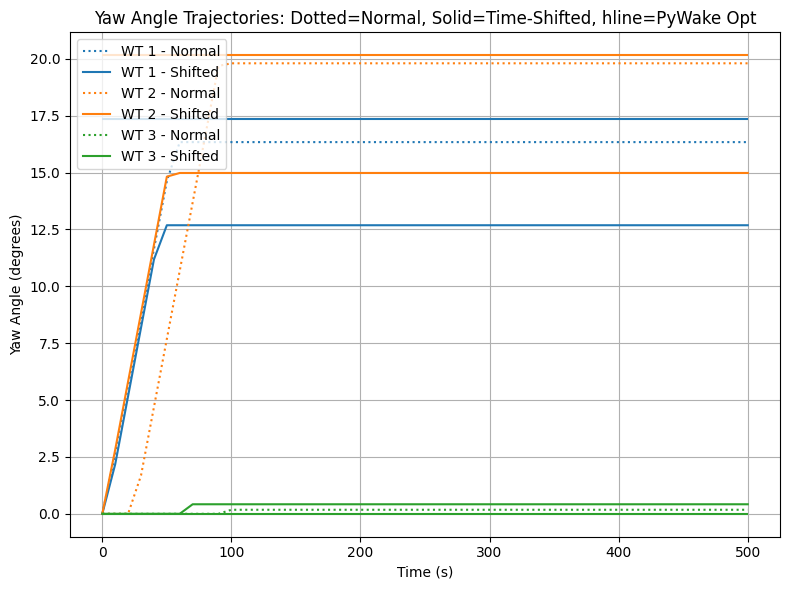

In [156]:
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(x_pos)):
    ax.plot(t, traj_normal[i], label=f'WT {i+1} - Normal', linestyle='dotted', color=f'C{i}')
    ax.plot(t, traj_shifted[i], label=f'WT {i+1} - Shifted', linestyle='solid', color=f'C{i}')


# Make x lines for values in pywake_agent.optimized_yaws
for i, yaw in enumerate(pywake_agent.optimized_yaws):
    ax.hlines(yaw, xmin=t[0], xmax=t[-1], colors=f'C{i}', linestyles='solid')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Yaw Angle (degrees)')
ax.set_title('Yaw Angle Trajectories: Dotted=Normal, Solid=Time-Shifted, hline=PyWake Opt')
ax.legend()
ax.grid()



plt.tight_layout()
plt.show()


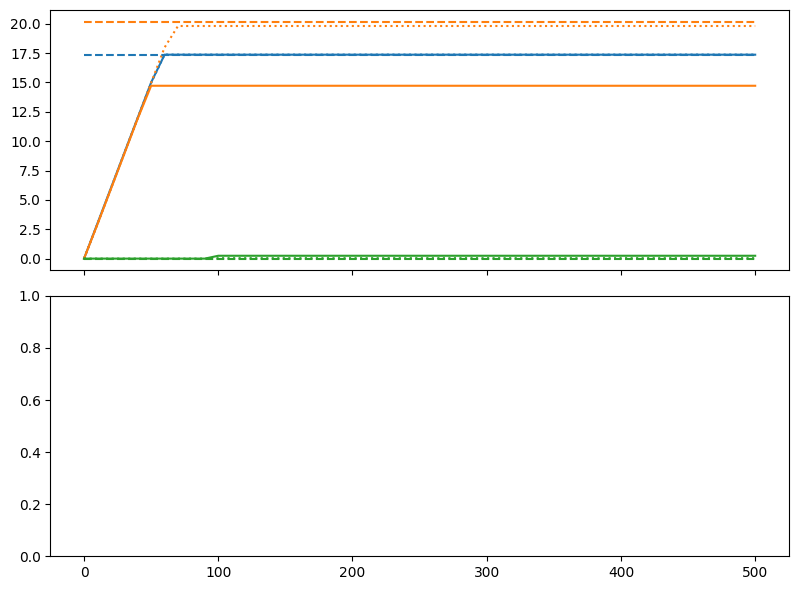

In [148]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for i in range(len(x_pos)):
    axs[0].plot(t, traj_normal[i], label=f'WT {i+1}', linestyle='dotted', color=f'C{i}')
    axs[0].plot(t, traj_shifted[i], label=f'WT {i+1}', linestyle='solid', color=f'C{i}')



# for i, power in enumerate(P):
#     axs[1].plot(t, power, label=f'WT {i+1}')

# axs[0].set_ylabel('Yaw angle [deg]')
# axs[0].set_title('Yaw angle trajectories')
# axs[0].legend()
# axs[0].grid()

# Make x lines for values in pywake_agent.optimized_yaws
for i, yaw in enumerate(pywake_agent.optimized_yaws):
    axs[0].hlines(yaw, xmin=t[0], xmax=t[-1], colors=f'C{i}', linestyles='dashed')


# axs[1].set_xlabel('Time [s]')
# axs[1].set_ylabel('Power [W]')
# axs[1].set_title('Wind turbines power output')
# axs[1].legend()
# axs[1].grid()

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Optional

def make_winner_heatmaps(
    df: pd.DataFrame,
    budget: int,
    out_dir: str,
    title_prefix: str = "Best optimizer by inflow",
    dpi: int = 200,
    collapse_over_TI: bool = False,
):
    """
    Create heatmaps of which method 'wins' for each (WS, WD, TI) at a fixed budget.

    Parameters
    ----------
    df : DataFrame
        Benchmark results.csv (one row per run). Must contain:
        WS, WD, TI, method, budget, gain_pct
    budget : int
        Which per-turbine budget to visualize (must match entries in df['budget'])
    out_dir : str
        Where to save the figure(s)
    collapse_over_TI : bool
        If False (default): make 1 subplot per TI value.
        If True: first average gain_pct over TI for each (WS, WD, method),
                 then choose the winner. Produces one single heatmap.

    Output
    ------
    Saves figure(s) in out_dir:
      - heatmap_winners_budget{budget}.png
        or, for multi-TI,
      - heatmap_winners_budget{budget}_TI{TI}.png
    """

    os.makedirs(out_dir, exist_ok=True)

    # 1) restrict to chosen budget and drop rows with NaN gain_pct
    sub = df[(df["budget"] == budget) & (~df["gain_pct"].isna())].copy()
    if sub.empty:
        print(f"[heatmap] No data for budget={budget}")
        return

    # 2) Average gain over reps/seeds for stability
    # We'll get mean gain per (WS, WD, TI, method)
    grp_cols = ["WS", "WD", "TI", "method"]
    avg = (sub.groupby(grp_cols, as_index=False)
               .agg(mean_gain_pct=("gain_pct", "mean")))

    if collapse_over_TI:
        # collapse TI by averaging over TI first
        grp_cols2 = ["WS", "WD", "method"]
        avg2 = (avg.groupby(grp_cols2, as_index=False)
                   .agg(mean_gain_pct=("mean_gain_pct", "mean")))
        # Now choose winner per (WS, WD)
        winners = (avg2.sort_values(["WS", "WD", "mean_gain_pct"], ascending=[True, True, False])
                        .groupby(["WS", "WD"], as_index=False)
                        .first())
        # winners has columns: WS, WD, method, mean_gain_pct

        _plot_single_heatmap(
            winners=winners,
            ws_col="WS",
            wd_col="WD",
            method_col="method",
            out_path=os.path.join(out_dir, f"heatmap_winners_budget{budget}_collapsedTI.png"),
            title=f"{title_prefix}\n(budget={budget}, TI averaged)",
        )
    else:
        # don't collapse TI: do one figure per TI
        for ti_val, df_ti in avg.groupby("TI"):
            # choose winner per (WS, WD) for this TI
            winners_ti = (
                df_ti.sort_values(["WS", "WD", "mean_gain_pct"],
                                  ascending=[True, True, False])
                     .groupby(["WS", "WD"], as_index=False)
                     .first()
            )
            # winners_ti has WS, WD, method, TI, mean_gain_pct
            _plot_single_heatmap(
                winners=winners_ti,
                ws_col="WS",
                wd_col="WD",
                method_col="method",
                out_path=os.path.join(out_dir, f"heatmap_winners_budget{budget}_TI{ti_val}.png"),
                title=f"{title_prefix}\n(budget={budget}, TI={ti_val})",
            )


def _plot_single_heatmap(
    winners: pd.DataFrame,
    ws_col: str,
    wd_col: str,
    method_col: str,
    out_path: str,
    title: str,
):
    """
    Internal helper to plot a categorical heatmap.

    winners: rows like [WS, WD, method]
    We'll pivot WS (y-axis) vs WD (x-axis).
    """

    # Sort unique values for axes
    ws_vals = np.sort(winners[ws_col].unique())
    wd_vals = np.sort(winners[wd_col].unique())

    # Map methods -> integer IDs
    methods = winners[method_col].unique()
    methods_sorted = sorted(methods)
    method_to_id = {m: i for i, m in enumerate(methods_sorted)}

    # Fill matrix of shape (len(ws_vals), len(wd_vals))
    grid = np.full((len(ws_vals), len(wd_vals)), fill_value=np.nan, dtype=float)

    # We'll also store which method each cell corresponds to,
    # and build a label matrix so we can optionally annotate.
    for _, row in winners.iterrows():
        ws = row[ws_col]
        wd = row[wd_col]
        m = row[method_col]
        ws_idx = np.where(ws_vals == ws)[0][0]
        wd_idx = np.where(wd_vals == wd)[0][0]
        grid[ws_idx, wd_idx] = method_to_id[m]

    # Create a ListedColormap with one color per method.
    # We'll just use tab10 cycling to make it readable.
    cmap_base = plt.get_cmap("tab10")
    colors = [cmap_base(i % 10) for i in range(len(methods_sorted))]
    cmap = mcolors.ListedColormap(colors)

    fig, ax = plt.subplots(figsize=(6, 4))
    # imshow expects row index as y, column index as x.
    im = ax.imshow(grid, interpolation="nearest", cmap=cmap,
                   origin="lower",
                   extent=[wd_vals[0], wd_vals[-1], ws_vals[0], ws_vals[-1]],
                   aspect="auto",
                   vmin=-0.5,
                   vmax=len(methods_sorted) - 0.5)

    ax.set_title(title)
    ax.set_xlabel("Wind direction [deg]")
    ax.set_ylabel("Wind speed [m/s]")

    # Put ticks at actual WD/WS values (not continuous colormap ticks)
    ax.set_xticks(wd_vals)
    ax.set_yticks(ws_vals)

    # Build legend manually
    handles = []
    for m, idx in method_to_id.items():
        handles.append(
            plt.Line2D([0], [0],
                       marker="s",
                       linestyle="",
                       markerfacecolor=colors[idx],
                       markeredgecolor="k",
                       label=m)
        )
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

    # Optional: annotate each cell with method short name
    for i_ws, ws in enumerate(ws_vals):
        for i_wd, wd in enumerate(wd_vals):
            method_idx = grid[i_ws, i_wd]
            if np.isnan(method_idx):
                continue
            # find text label from id
            m_name = [m for m, mid in method_to_id.items() if mid == method_idx][0]
            ax.text(
                wd,
                ws,
                m_name,
                ha="center",
                va="center",
                fontsize=6,
                color="white",
                path_effects=[],
            )

    fig.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)


In [14]:
df = pd.read_csv("/home/marcus/Documents/mpcrl/benchmark_out_mp/results.csv")

In [16]:
import os

In [17]:

# Example 1: one heatmap per TI, budget=20
make_winner_heatmaps(
    df,
    budget=20,
    out_dir="benchmark_out_mp",
    collapse_over_TI=False,
    title_prefix="Best optimizer per inflow (no TI collapse)"
)

In [18]:
# Example 2: single heatmap averaged across TI, budget=20
make_winner_heatmaps(
    df,
    budget=20,
    out_dir="benchmark_out_mp",
    collapse_over_TI=True,
    title_prefix="Best optimizer per inflow (TI averaged)"
)


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import os

def heatmap_winner_by_inflow(df: pd.DataFrame, budget: int, output_dir: str,
                             tie_break: str = "time",  # or "none": mark ties
                             by_ti: bool = True):
    """
    For a fixed budget, choose the method with the highest mean Δ% gain per (WS, WD[, TI]).
    If tie_break == "time": break ties by lowest mean total_time_s.
    If tie_break == "none": ties are marked as -1 (gray).

    Saves one PNG per TI (if by_ti=True), or a single PNG aggregated over TI (if by_ti=False).
    """
    os.makedirs(output_dir, exist_ok=True)
    dsub = df[(df["budget"] == budget) & (~df["gain_pct"].isna())].copy()
    if dsub.empty:
        print(f"[heatmap] No rows for budget={budget}.")
        return

    # Aggregate per (WS, WD, TI, method): mean gain and mean total time
    grp_cols = ["WS", "WD", "TI", "method"] if by_ti else ["WS", "WD", "method"]
    agg = (dsub.groupby(grp_cols, as_index=False)
                .agg(mean_gain=("gain_pct", "mean"),
                     mean_time=("total_time_s", "mean"),
                     n=("gain_pct", "count")))

    # Which TI slices to render
    ti_values = sorted(agg["TI"].unique()) if by_ti else [None]

    # Stable method order and color palette
    methods = list(sorted(agg["method"].unique()))
    method_to_idx = {m: i for i, m in enumerate(methods)}
    # Choose distinct colors (append grey for ties)
    palette = ListedColormap([
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#17becf", "#bcbd22"
    ][:len(methods)])
    tie_color = "#999999"

    for ti in ti_values:
        if by_ti:
            sl = agg[agg["TI"] == ti].copy()
            title_suffix = f" (TI={ti})"
            fname_suffix = f"_TI_{str(ti).replace('.','p')}"
        else:
            sl = agg.copy()
            title_suffix = " (all TI)"
            fname_suffix = "_allTI"

        if sl.empty:
            print(f"[heatmap] No data for TI={ti} at budget={budget}")
            continue

        # Build winner table: for each (WS, WD) choose method with max mean_gain
        winners = []
        for (ws, wd), g in sl.groupby(["WS", "WD"]):
            # Find best mean_gain; handle ties
            g_sorted = g.sort_values("mean_gain", ascending=False)
            top_gain = g_sorted.iloc[0]["mean_gain"]
            contenders = g[g["mean_gain"].round(10) == round(top_gain, 10)]

            if len(contenders) > 1 and tie_break == "time":
                # break tie by faster mean_time
                contenders = contenders.sort_values("mean_time", ascending=True).head(1)

            if len(contenders) == 1:
                m = contenders.iloc[0]["method"]
                winners.append({"WS": ws, "WD": wd, "method": m, "idx": method_to_idx[m]})
            else:
                # Either multiple ties and tie_break == "none", or weird situation
                winners.append({"WS": ws, "WD": wd, "method": "TIE", "idx": -1})

        W = pd.DataFrame(winners)

        # Create WS×WD grid (rows: WS ascending, cols: WD ascending)
        ws_vals = sorted(W["WS"].unique())
        wd_vals = sorted(W["WD"].unique())
        mat = np.full((len(ws_vals), len(wd_vals)), -1, dtype=int)  # -1 means tie/NA
        for i, ws in enumerate(ws_vals):
            for j, wd in enumerate(wd_vals):
                row = W[(W["WS"] == ws) & (W["WD"] == wd)]
                if not row.empty:
                    mat[i, j] = int(row.iloc[0]["idx"])

        # Plot categorical heatmap with custom legend
        fig, ax = plt.subplots(figsize=(1.2*len(wd_vals)+2, 0.9*len(ws_vals)+2))
        # Build colors including tie gray if present
        colors = list(palette.colors)
        if (mat == -1).any():
            colors = [tie_color] + colors
            # shift indices by +1 to map -1->0, 0->1, etc.
            mat_plot = mat.copy()
            mat_plot[mat_plot >= 0] += 1
        else:
            mat_plot = mat

        cmap = ListedColormap(colors)
        im = ax.imshow(mat_plot, aspect="auto", cmap=cmap, interpolation="nearest")

        ax.set_xticks(range(len(wd_vals)))
        ax.set_xticklabels([f"{wd:.0f}°" for wd in wd_vals], rotation=0)
        ax.set_yticks(range(len(ws_vals)))
        ax.set_yticklabels([f"{ws:.1f} m/s" for ws in ws_vals])
        ax.set_xlabel("Wind direction (WD)")
        ax.set_ylabel("Wind speed (WS)")
        ax.set_title(f"Winner per inflow at budget={budget}{title_suffix}")

        # Legend
        handles = []
        if (mat == -1).any():
            handles.append(Patch(facecolor=tie_color, edgecolor="k", label="Tie"))
        for m, idx in method_to_idx.items():
            # map idx to color index in the drawn cmap
            color_idx = idx + (1 if (mat == -1).any() else 0)
            handles.append(Patch(facecolor=cmap.colors[color_idx], edgecolor="k", label=m))
        ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

        fig.tight_layout()
        out_path = os.path.join(output_dir, f"heatmap_winner_budget_{budget}{fname_suffix}.png")
        fig.savefig(out_path, dpi=200)
        plt.close(fig)
        print(f"[heatmap] Saved {out_path}")


In [20]:
def heatmap_gain_for_method(df: pd.DataFrame, budget: int, method: str,
                            output_dir: str, by_ti: bool = True):
    os.makedirs(output_dir, exist_ok=True)
    dsub = df[(df["budget"] == budget) & (df["method"] == method) & (~df["gain_pct"].isna())]
    if dsub.empty:
        print(f"[heatmap-gain] No data for method={method}, budget={budget}")
        return

    grp_cols = ["WS", "WD", "TI"] if by_ti else ["WS", "WD"]
    agg = dsub.groupby(grp_cols, as_index=False).agg(mean_gain=("gain_pct", "mean"))

    ti_values = sorted(agg["TI"].unique()) if by_ti else [None]
    for ti in ti_values:
        sl = agg[agg["TI"] == ti] if by_ti else agg
        if sl.empty: 
            continue

        ws_vals = sorted(sl["WS"].unique())
        wd_vals = sorted(sl["WD"].unique())
        mat = np.full((len(ws_vals), len(wd_vals)), np.nan, dtype=float)
        for i, ws in enumerate(ws_vals):
            for j, wd in enumerate(wd_vals):
                r = sl[(sl["WS"] == ws) & (sl["WD"] == wd)]
                if not r.empty:
                    mat[i, j] = float(r.iloc[0]["mean_gain"])

        fig, ax = plt.subplots(figsize=(1.2*len(wd_vals)+2, 0.9*len(ws_vals)+2))
        im = ax.imshow(mat, aspect="auto", cmap="viridis", interpolation="nearest")
        ax.set_xticks(range(len(wd_vals))); ax.set_xticklabels([f"{wd:.0f}°" for wd in wd_vals])
        ax.set_yticks(range(len(ws_vals))); ax.set_yticklabels([f"{ws:.1f} m/s" for ws in ws_vals])
        ax.set_xlabel("Wind direction (WD)"); ax.set_ylabel("Wind speed (WS)")
        ti_suffix = f" (TI={ti})" if by_ti else " (all TI)"
        ax.set_title(f"Mean Δ% gain — {method}, budget={budget}{ti_suffix}")
        cb = plt.colorbar(im, ax=ax); cb.set_label("Δ% energy vs baseline")

        fig.tight_layout()
        out_path = os.path.join(output_dir, f"heatmap_gain_{method}_budget_{budget}{'_TI_'+str(ti).replace('.','p') if by_ti else '_allTI'}.png")
        fig.savefig(out_path, dpi=200)
        plt.close(fig)
        print(f"[heatmap-gain] Saved {out_path}")


In [21]:
out_dir = "benchmark_out_mp/heatmaps"

In [22]:
# Winner heatmaps at representative budgets (e.g., 10 and 30)
for b in [10, 30]:
    heatmap_winner_by_inflow(df, budget=b, output_dir=out_dir, tie_break="time", by_ti=True)

# Optional: per-method gain maps
for m in sorted(df["method"].dropna().unique()):
    heatmap_gain_for_method(df, budget=30, method=m, output_dir=out_dir, by_ti=True)

[heatmap] Saved benchmark_out_mp/heatmaps/heatmap_winner_budget_10_TI_0p05.png
[heatmap] Saved benchmark_out_mp/heatmaps/heatmap_winner_budget_10_TI_0p06.png
[heatmap] Saved benchmark_out_mp/heatmaps/heatmap_winner_budget_10_TI_0p1.png
[heatmap] Saved benchmark_out_mp/heatmaps/heatmap_winner_budget_30_TI_0p05.png
[heatmap] Saved benchmark_out_mp/heatmaps/heatmap_winner_budget_30_TI_0p06.png
[heatmap] Saved benchmark_out_mp/heatmaps/heatmap_winner_budget_30_TI_0p1.png
[heatmap-gain] Saved benchmark_out_mp/heatmaps/heatmap_gain_direct_budget_30_TI_0p05.png
[heatmap-gain] Saved benchmark_out_mp/heatmaps/heatmap_gain_direct_budget_30_TI_0p06.png
[heatmap-gain] Saved benchmark_out_mp/heatmaps/heatmap_gain_direct_budget_30_TI_0p1.png
[heatmap-gain] Saved benchmark_out_mp/heatmaps/heatmap_gain_dual_annealing_budget_30_TI_0p05.png
[heatmap-gain] Saved benchmark_out_mp/heatmaps/heatmap_gain_dual_annealing_budget_30_TI_0p06.png
[heatmap-gain] Saved benchmark_out_mp/heatmaps/heatmap_gain_dual_ann

In [40]:
import os
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pareto_gain_vs_time_logx(
    df: pd.DataFrame,
    out_path: str = "pareto_gain_vs_time_logx.png",
    ti: float | None = None,       # set to a TI value to slice, or None to aggregate all
    title_suffix: str = "",
):
    """
    Create a Pareto plot: mean Δ% energy (y) vs mean total time [s] (x, log scale),
    aggregated by (method, budget). Annotates each point with the budget.
    """
    data = df.copy()
    data = data.dropna(subset=["gain_pct", "total_time_s"])

    if ti is not None:
        data = data[np.isclose(data["TI"], ti)]
        title_suffix = f" (TI={ti})" + (f" {title_suffix}" if title_suffix else "")

    # Aggregate
    agg = (data
           .groupby(["method", "budget"], as_index=False)
           .agg(mean_gain_pct=("gain_pct", "mean"),
                std_gain_pct=("gain_pct", "std"),
                mean_total_time_s=("total_time_s", "mean"),
                std_total_time_s=("total_time_s", "std"),
                n=("gain_pct", "count"))
           .sort_values(["method", "budget"]))

    if agg.empty:
        raise ValueError("No data to plot after filtering. Check inputs/filters.")

    fig, ax = plt.subplots(figsize=(8, 5))
    for i, method in enumerate(agg["method"].unique()):
        sub = agg[agg["method"] == method]
        # Line to show the trade-off curve per method
        ax.plot(sub["mean_total_time_s"], sub["mean_gain_pct"], 
                marker="o", label=method, color=f"C{i}",
                markersize=16,)
        # Optional error bars
        ax.errorbar(sub["mean_total_time_s"], sub["mean_gain_pct"],
                    xerr=sub["std_total_time_s"], yerr=sub["std_gain_pct"],
                    fmt="none", alpha=0.5, capsize=2, color=f"C{i}")
        # Annotate budgets
        for _, r in sub.iterrows():
            ax.annotate(f"{int(r['budget'])}",
                        (r["mean_total_time_s"], r["mean_gain_pct"]),
                        textcoords="offset points", xytext=(5, 5), fontsize=8)

    ax.set_xscale("log")
    ax.set_xlabel("Mean total time [s] (log scale)")
    ax.set_ylabel("Mean Δ% energy vs baseline")
    ax.set_title("Pareto: Energy gain vs total time" + (f" {title_suffix}" if title_suffix else ""))
    ax.grid(True, which="both", alpha=0.3)
    ax.legend()
    fig.tight_layout()

    # os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    # fig.savefig(out_path, dpi=200)
    # plt.close(fig)
    plt.show()
    return agg  # handy if you want to inspect what was plotted


In [41]:
df["TI"].unique()

array([0.05, 0.06, 0.1 ])

In [45]:
# remove all where budget = 5
df_small = df[df["budget"] != 5]

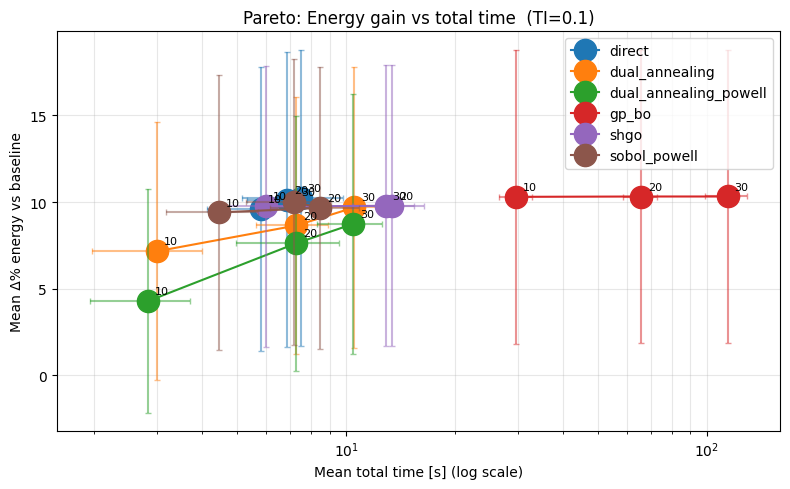

In [47]:

# All TI values combined
data = pareto_gain_vs_time_logx(df_small, out_path="benchmark_out_mp/pareto_gain_vs_time_logx.png", ti=0.1)
